<a href="https://colab.research.google.com/github/MiguelAngeloTr/BIGDATA/blob/main/C3/KNN_SVM_Classifier_PySpark_BigData_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q --upgrade pyspark
!pip install -q findspark
!pip install -q dask-ml

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.8/149.8 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 237.3/237.3 kB 9.6 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import zipfile
import os, pathlib, PIL, shutil, glob
from google.colab import files

import matplotlib.pyplot as plt
from pandas.core.dtypes.api import is_numeric_dtype, is_string_dtype

from pyspark.sql import SparkSession, DataFrame
from pyspark import SparkFiles
import pyspark.sql.functions as F
import pyspark.sql.window as W
import pyspark.sql.types as T

from dask_ml.model_selection import GridSearchCV, RandomizedSearchCV
from dask.distributed import Client

from pyspark.ml.feature import VectorAssembler, MinMaxScaler, StandardScaler, OneHotEncoder, StringIndexer
from pyspark.ml import Pipeline

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
from mlxtend.plotting import plot_confusion_matrix
from mlxtend.evaluate import confusion_matrix

In [ ]:
spark = SparkSession.builder.appName("KNN - SVM Classification PySpark").getOrCreate()
spark

In [ ]:
client = Client(n_workers=4, threads_per_worker=4)

/usr/local/lib/python3.10/dist-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 46459 instead
  warnings.warn(
INFO:distributed.scheduler:State start
INFO:distributed.scheduler:  Scheduler at:     tcp://127.0.0.1:36007
INFO:distributed.scheduler:  dashboard at:  http://127.0.0.1:46459/status
INFO:distributed.scheduler:Registering Worker plugin shuffle
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:37227'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:44733'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:45607'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:37275'
INFO:distributed.scheduler:Register worker <WorkerState 'tcp://127.0.0.1:33413', name: 0, status: init, memory: 0, processing: 0>
INFO:distributed.scheduler:Starting worker compute stream, tcp://127.0.0.1:33413
INFO:distributed.core:Starting established conne

In [ ]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sergiocantilloluna","key":"980459bf1a5e086badcd17a967d6d335"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d bharath011/heart-disease-classification-dataset
!ls

Dataset URL: https://www.kaggle.com/datasets/bharath011/heart-disease-classification-dataset
License(s): Attribution 4.0 International (CC BY 4.0)
  0% 0.00/15.8k [00:00<?, ?B/s]
100% 15.8k/15.8k [00:00<00:00, 24.0MB/s]
heart-disease-classification-dataset.zip  kaggle.json  sample_data


In [ ]:
zip_ref = zipfile.ZipFile('heart-disease-classification-dataset.zip', 'r') #localizar el nombre del archivo .zip y colocarlo
zip_ref.extractall('Data') #Extracción de archivos descargados en una carpeta llamada 'files', podria ser cualquier nombre
zip_ref.close()

In [ ]:
datos = spark.read.csv('/content/Data/Heart Attack.csv',inferSchema=True, header=True)
datos.show(5, truncate=False)

+---+------+-------+-------------+-----------+-------+-----+--------+--------+
|age|gender|impluse|pressurehight|pressurelow|glucose|kcm  |troponin|class   |
+---+------+-------+-------------+-----------+-------+-----+--------+--------+
|64 |1     |66     |160          |83         |160.0  |1.8  |0.012   |negative|
|21 |1     |94     |98           |46         |296.0  |6.75 |1.06    |positive|
|55 |1     |64     |160          |77         |270.0  |1.99 |0.003   |negative|
|64 |1     |70     |120          |55         |270.0  |13.87|0.122   |positive|
|55 |1     |64     |112          |65         |300.0  |1.08 |0.003   |negative|
+---+------+-------+-------------+-----------+-------+-----+--------+--------+
only showing top 5 rows



In [ ]:
datos.printSchema()

root
 |-- age: integer (nullable = true)
 |-- gender: integer (nullable = true)
 |-- impluse: integer (nullable = true)
 |-- pressurehight: integer (nullable = true)
 |-- pressurelow: integer (nullable = true)
 |-- glucose: double (nullable = true)
 |-- kcm: double (nullable = true)
 |-- troponin: double (nullable = true)
 |-- class: string (nullable = true)



#Informacion Faltante y Columnas innecesarias


In [ ]:
#datos_f1 = datos.drop("duration")
#datos_f1.show(5, truncate=False)

In [ ]:
def faltantes(df):
  falta = df.select([F.sum(F.col(c).isNull().cast('int')).alias(c) for c in df.columns])
  return falta.show()

In [ ]:
faltantes(datos)

+---+------+-------+-------------+-----------+-------+---+--------+-----+
|age|gender|impluse|pressurehight|pressurelow|glucose|kcm|troponin|class|
+---+------+-------+-------------+-----------+-------+---+--------+-----+
|  0|     0|      0|            0|          0|      0|  0|       0|    0|
+---+------+-------+-------------+-----------+-------+---+--------+-----+



# Analisis Exploratorio de Datos (EDA)

In [ ]:
numeric_features = [t[0] for t in datos.dtypes if t[1] == 'int' or t[1] == 'double']
datos.select(numeric_features).describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
age,1319,56.191811978771796,13.647315476078793,14,103
gender,1319,0.6595905989385898,0.4740265793910884,0,1
impluse,1319,78.3366186504928,51.630270006756234,20,1111
pressurehight,1319,127.17058377558757,26.122720455841314,42,223
pressurelow,1319,72.26914329037149,14.033924163048681,38,154
glucose,1319,146.63434420015165,74.92304465780164,35.0,541.0
kcm,1319,15.274305534495856,46.32708334398737,0.321,300.0
troponin,1319,0.3609423805913552,1.154567664922181,0.001,10.3


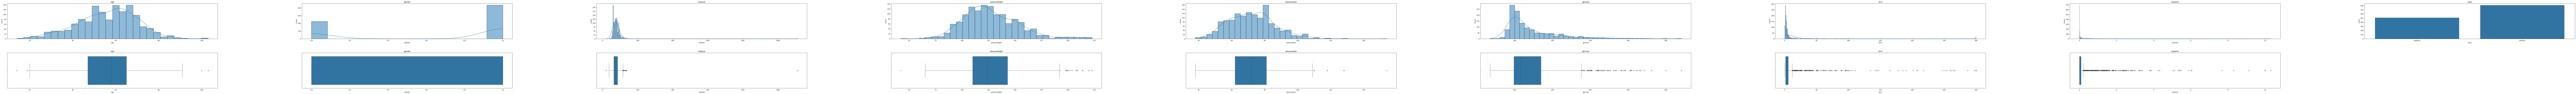

In [ ]:
datos_EDA = datos.toPandas()
num_list = []
cat_list = []

fig, axes = plt.subplots(2, len(datos_EDA.columns), figsize=(300, 10))  # Ajusta el tamaño según sea necesario
fig.subplots_adjust(hspace=0.4, wspace=0.4)

axes = axes.flatten()

# Contador para los gráficos
graph_count = 0

# Iterar sobre las columnas del DataFrame
for column in datos_EDA.columns:
    if is_numeric_dtype(datos_EDA[column]):
        # Histograma en la primera fila
        sns.histplot(datos_EDA[column], kde=True, ax=axes[graph_count])
        axes[graph_count].set_title(f"{column}")

        # Boxplot en la segunda fila
        sns.boxplot(x=datos_EDA[column], ax=axes[graph_count + len(datos_EDA.columns)])
        axes[graph_count + len(datos_EDA.columns)].set_title(f"{column}")
        num_list.append(column)
        graph_count += 1  # Pasar al siguiente gráfico

    elif is_string_dtype(datos_EDA[column]):
        sns.countplot(data=datos_EDA, x=datos_EDA[column], ax=axes[graph_count])
        axes[graph_count].set_title(f"{column}")
        cat_list.append(column)
        axes[graph_count + len(datos_EDA.columns)].axis("off")
        graph_count += 1  # Pasar al siguiente gráfico

# Mostrar la gráfica
plt.show()

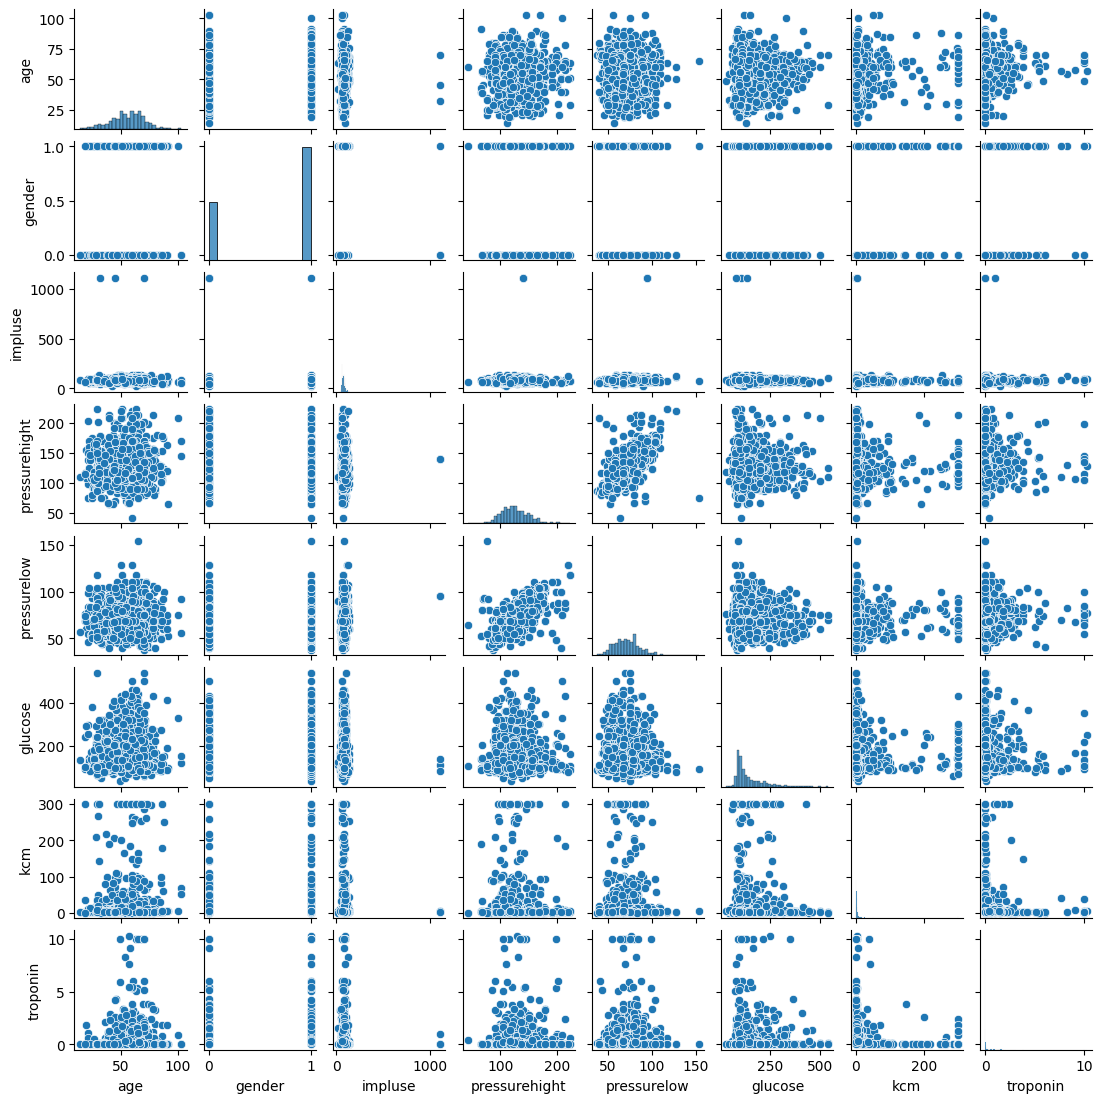

In [ ]:
numeric_data = datos.select(numeric_features).toPandas()
sns.pairplot(numeric_data, height=1.4)
plt.show()

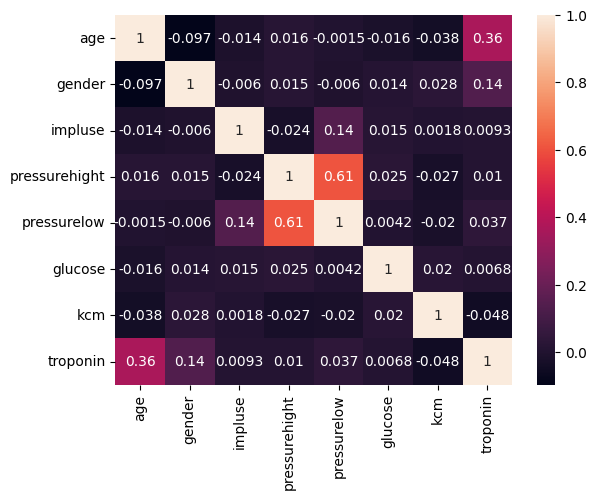

In [ ]:
sns.heatmap(numeric_data.corr('spearman'),annot=True)
plt.show()

In [ ]:
datos_f1 = datos.select('age', 'gender', 'impluse', 'pressurehight', 'pressurelow', 'glucose','kcm','troponin','class')
cols = datos.columns
datos_f1.printSchema()

root
 |-- age: integer (nullable = true)
 |-- gender: integer (nullable = true)
 |-- impluse: integer (nullable = true)
 |-- pressurehight: integer (nullable = true)
 |-- pressurelow: integer (nullable = true)
 |-- glucose: double (nullable = true)
 |-- kcm: double (nullable = true)
 |-- troponin: double (nullable = true)
 |-- class: string (nullable = true)



# Construcción del vector de caracteristicas

In [ ]:
salida = 'class'
caracteristicas = [car for car in cols if car not in salida]
cat_car = [c for c, t in datos_f1.dtypes if t == 'string' and c not in salida]
num_car = [c for c, t in datos_f1.dtypes if t in ['int', 'double'] and c not in salida]
print('Cat:',cat_car,'\nNum:', num_car)

Cat: [] 
Num: ['age', 'gender', 'impluse', 'pressurehight', 'pressurelow', 'glucose', 'kcm', 'troponin']


In [ ]:
indexers = [StringIndexer(inputCol = col,
                          outputCol = "c_{}".format(col)) for col in cat_car]

encoders = [OneHotEncoder(inputCol = "c_{}".format(col),
                          outputCol = "o_{}".format(col)) for col in cat_car]

assembler = VectorAssembler(inputCols = num_car + ["o_{}".format(col) for col in cat_car], outputCol = "features")

labelIndexer = StringIndexer(inputCol=salida, outputCol='label') if salida in datos_f1.columns else None

preprocessor = Pipeline(stages = indexers + encoders + [assembler] + [labelIndexer]).fit(datos_f1)


In [ ]:
datos_f2 = preprocessor.transform(datos_f1)
selectedCols = ['label', 'features'] #+ cols
datos_f3 = datos_f2.select(selectedCols)
datos_f3.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)



In [ ]:
datos_f3.show(5,truncate=False)

+-----+--------------------------------------------+
|label|features                                    |
+-----+--------------------------------------------+
|1.0  |[64.0,1.0,66.0,160.0,83.0,160.0,1.8,0.012]  |
|0.0  |[21.0,1.0,94.0,98.0,46.0,296.0,6.75,1.06]   |
|1.0  |[55.0,1.0,64.0,160.0,77.0,270.0,1.99,0.003] |
|0.0  |[64.0,1.0,70.0,120.0,55.0,270.0,13.87,0.122]|
|1.0  |[55.0,1.0,64.0,112.0,65.0,300.0,1.08,0.003] |
+-----+--------------------------------------------+
only showing top 5 rows



## División de conjuntos de ajuste (entrenamiento) y prueba

In [ ]:
train, test = datos_f3.randomSplit([0.7, 0.3], seed = 2024)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 932
Test Dataset Count: 387


In [ ]:
train = train.select("features", "label").toPandas()
test = test.select("features", "label").toPandas()

In [ ]:
X_train = pd.DataFrame(train["features"].tolist(), columns=cols[:-1])
X_test = pd.DataFrame(test["features"].tolist(), columns=cols[:-1])
y_train, y_test = train["label"], test["label"]

# SVC

In [ ]:
cls_SVC = SVC()
param_grid = {"C": [0.01, 0.1, 1.0, 3.0, 10.0],
              "kernel": ["rbf", "poly", "sigmoid", "linear"]
              }

In [ ]:
gs_SVC = RandomizedSearchCV(cls_SVC, param_grid, n_iter=10, scheduler=client, random_state=42).fit(X_train, y_train)
print("Mejores hiperparámetros:", gs_SVC.best_params_)

Mejores hiperparámetros: {'kernel': 'linear', 'C': 3.0}


# KNN

In [ ]:
cls_KNN = KNeighborsClassifier()
param_grid = {"n_neighbors": range(3,20),
              "p":[1,2],
              "metric":['euclidean','minkowski']}

In [ ]:
gs_KNN = RandomizedSearchCV(cls_KNN, param_grid, n_iter=15, scheduler=client, random_state=42).fit(X_train, y_train)
print("Mejores hiperparámetros:", gs_KNN.best_params_)

Mejores hiperparámetros: {'p': 2, 'n_neighbors': 16, 'metric': 'minkowski'}


# Validación

In [ ]:
def calculate_metrics(y_true, y_pred):
    # Calcular otras métricas utilizando sklearn
    accuracy = accuracy_score(y_true, y_pred)*100
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    return {
        "Accuracy (%)": round(accuracy,2),
        "Precision": round(precision,2),
        "Recall": round(recall,2),
        "F1 Score": round(f1,2)
    }


In [ ]:
def conf_matrix(y_pred,y_test):
  fig, ax = plot_confusion_matrix(confusion_matrix(y_test, y_pred), show_normed=True,
                                  figsize=(3,3))
  fig.show()

In [ ]:
test_res_SVC, train_res_KNN = gs_SVC.predict(X_test), gs_KNN.predict(X_train)
train_res_SVC, test_res_KNN = gs_SVC.predict(X_train), gs_KNN.predict(X_test)

## Métricas de Rendimiento

### Entrenamiento

In [ ]:
print("Métricas en datos de entrenamiento (SVC):\n")
train_metrics = calculate_metrics(train_res_SVC, y_train)
for metric, value in train_metrics.items():
    print(f"{metric}: {value}")

print("\nMétricas en datos de entrenamiento (KNN):\n")
train_metrics = calculate_metrics(train_res_KNN, y_train)
for metric, value in train_metrics.items():
    print(f"{metric}: {value}")

Métricas en datos de entrenamiento (SVC):

Accuracy (%): 81.33
Precision: 0.82
Recall: 0.81
F1 Score: 0.81

Métricas en datos de entrenamiento (KNN):

Accuracy (%): 68.67
Precision: 0.77
Recall: 0.69
F1 Score: 0.71


(None, None)

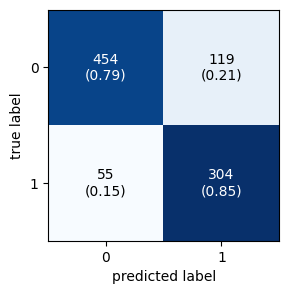

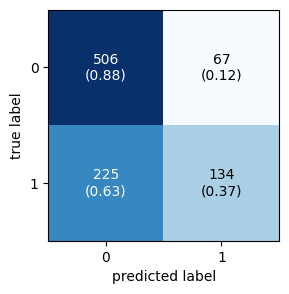

In [ ]:
conf_matrix(train_res_SVC,y_train), conf_matrix(train_res_KNN,y_train)

## Prueba

In [ ]:
print("Métricas en datos de prueba (SVC):\n")
test_metrics = calculate_metrics(test_res_SVC,y_test)
for metric, value in test_metrics.items():
    print(f"{metric}: {value}")

print("\nMétricas en datos de prueba (KNN):\n")
train_metrics = calculate_metrics(test_res_KNN, y_test)
for metric, value in train_metrics.items():
    print(f"{metric}: {value}")

Métricas en datos de prueba (SVC):

Accuracy (%): 81.14
Precision: 0.81
Recall: 0.81
F1 Score: 0.81

Métricas en datos de prueba (KNN):

Accuracy (%): 65.12
Precision: 0.72
Recall: 0.65
F1 Score: 0.67


(None, None)

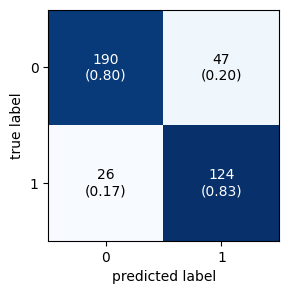

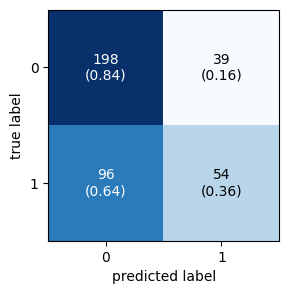

In [ ]:
conf_matrix(test_res_SVC,y_test), conf_matrix(test_res_KNN,y_test)